# Algorithme EM pour des mélanges gaussiens

Dans ce TP vous allez mettre en oeuvre l'algorithme EM pour un mélange gaussien de densité 
$$f_\theta(x)=\sum_{k=1}^K\pi_kf_{\mathcal N(\mu_k,\sigma^2_k)}(x),\qquad x\in\mathbb R,$$
où $0<\pi_k<1$, $\sum_{k=1}^K\pi_k=1$, $\mu_k\in\mathbb R$ et $\sigma_k>0$, $k=1,\dots,K$. 

Notons les paramèters du modèle par
$$\theta=\left(\pi_1,\dots,\pi_K,\mu_1,\dots,\mu_K,\sigma_1,\dots,\sigma_K\right)$$
Comme au dernier notebook, sous **R** nous allons stocker les paramètres dans une liste :


In [1]:
theta = list(pi=c(3,2,5)/10, mu=c(4,-5,0), sig=c(1.3,1,1.5))
theta

Soient $\mathbf x=(x_1,\dots,x_n)$ un échantillon du mélange gaussien de densité $f_\theta$.

L'algorithme EM est un algorithme itératif pour approcher l'EMV en tirant profit de la structure latente du modèle. Il consiste à calculer succéssivmeent pour $t=0,1,\dots$
\begin{align}
\theta^{(t+1)}=\arg\max_\theta Q(\theta|\theta^{(t)}),
\end{align}
     où $Q(\theta|\theta')$ est l'espérance conditionnelle de la fonction de log-vraisemblance des données complètes sous le paramètre $\theta'$, et  $\theta^{(0)}$ est un point initial choisi par l'utilisateur.
En cours, nous avon  montré que  $\theta^{(t+1)}$  est donné par
\begin{align}
\pi_k^{(t+1)}&= \frac1n\sum_{i=1}^n\alpha_{k|i}^{(t)},\quad  k=1,\dots,K \\
\mu_k^{(t+1)}&
=\frac1{n\pi_k^{(t+1)}}{\sum_{i=1}^nx_i\alpha_{k|i}^{(t)}},\quad k=1,\dots,K \qquad\qquad\qquad\qquad(*)\\
\sigma_k^{(t+1)} 
&= \sqrt{\frac1{n\pi_k^{(t+1)}}{ \sum_{i=1}^n\alpha_{k|i}^{(t)}(x_i-\mu_k^{(t+1)})^2}},\quad k=1,\dots,K
\end{align}



avec \begin{align}
\alpha_{k|i}^{(t)} = \mathbb P_{\theta^{(t)}}(Z=k|X=x_i)
= \frac{\pi_k^{(t)}f_{\mathcal N(\mu_k^{(t)},\sigma_k^{2(t)})}(x_i)}{f_{\theta^{(t)}}(x_i)},\quad k=1,\dots,K,i=1,\dots,n
.
\end{align}

## Question 1
- Ecrire une fonction **update.theta** pour  effectuer une mise à jour de la valeur actuelle du paramètre $\theta$. Autrement dit, la fonction calcule la valeur $\theta^{(t+1)}$  selon les formules $(*)$. La fonction prend en argument un vecteur d'observations **obs** et une liste de paramètres **theta** (le paramètres $\theta^{(t)})$, et elle renvoie une liste avec les paramètres mis à jour (le paramètre  $\theta^{(t+1)}$).
- Pour tester la fonction, appliquer **update.theta** à des données simulées d'un mélange gaussien et passer à la fonction les vraies valeurs des paramètres. Les paramètres retournés devraient être proches  des vraies valeurs. (Penser à reutiliser les fonctions que l'on a écrit au dernier TP.)


In [2]:
update.theta <- function(obs, theta){
  
  return(theta.new)
}

In [3]:
update.theta <- function(obs, theta){
  nb <- length(obs) 
  K  <- length(theta$mu) 
  
  # calcul des alpha_ji
  alpha <- matrix(NA,nrow=K, ncol=nb)
  for (j in 1:K){
    alpha[j,] <- theta$pi[j]*dnorm(obs,theta$mu[j],theta$sig[j])
  }
  p.theta <- apply(alpha,2,'sum')
  alpha   <- alpha/matrix(p.theta,byrow=TRUE,nrow=K,ncol=nb)
  
  # mise à jour des paramètres  
  pi.new  <- apply(alpha,1,'mean')
  mu.new  <- c(alpha%*%obs/nb/pi.new)
  mat     <- (matrix(rep(obs,each=K),nrow=K) -matrix(rep(mu.new,times=nb),nrow=K))^2
  sig.new <- sqrt(apply(alpha*mat,1,'mean')/pi.new)
  
  theta.new <-  list(pi =pi.new, mu=mu.new, sig=sig.new)
  return(theta.new)
}

In [4]:
rnormmix <- function(n,theta){
  K <- length(theta$pi)
  etiqu <- sample(1:K,size=n,replace=TRUE,prob=theta$pi)
  obs <- rep(NA,n)
  i <- 1
  for (k in 1:K){
    n.group <- sum(etiqu==k)
    if(n.group>0){
      obs[i:(i+n.group-1)] <- rnorm(n.group,theta$mu[k],theta$sig[k])
      i <- i + n.group
    }
  }        
  return(obs)
}

obs <- rnormmix(500,theta)
update.theta(obs,theta)

## Question 2

- Ecrire une fonction **algoEM** qui effectue l'algorithme EM. Ses arguments sont un vecteur d'observations **obs** et une liste avec les valeurs initiales des paramètres. Cette fonction retourne une liste avec les paramètres estimés par l'algorithme EM et le nombre d'itérations effectuées. 
Plus précisément, la fonction **algoEM** itère des mises à jours de paramètres par les formules en $(*)$ jusqu'à convergence. On utilise comme critère d'arrêt 
$$\left|\frac{\ell(\theta^{(t+1)})-\ell(\theta^{(t)})}{\ell(\theta^{(t)})}\right|<\varepsilon,$$
où $\ell(\theta)$ désigne la fonction de log-vraisemblance et avec $\varepsilon=10^{-3}$ comme seuil. Pour éviter que l'algorithme tourne indéfiniment, on s'arrête au plus tard après $R=200$ itérations. On peut déclarer $\varepsilon$ et $R$ comme des arguments de la fonction avec des valeurs par défaut.

- Testez votre fonction sur des données simulées en initialisant avec les vraies valeurs des paramètres. Visualiser la densité du mélange estimée par l'algorithme EM en la superposant à l'histogramme des données. Rajouter également la densité du mélange avec les vraies valeurs des paramètres.


In [5]:
algoEM <- function(obs, theta.init){   

  resultat <- list(emv = theta.new, nb.iter = it)
  return(resultat)
}

In [6]:
dnormmix <- function(x,theta){
  dens <- rep(0,length(x))
  K <- length(theta$pi)
  for (k in 1:K){
    dens <- dens + theta$pi[k]*dnorm(x,theta$mu[k],theta$sig[k])
  }                                         
  return(dens)
}

lvraisnorm <- function(param,obs){    
  logvrais <- sum(log(dnormmix(obs,param)))
  return(logvrais)
}

algoEM <- function(obs, theta.init, R=200, epsilon=1e-3){   
  theta.old <- theta.init
  crit_arret <- FALSE
  log.vrais.old <- lvraisnorm(theta.init,obs)
  it <- 0
  while (!crit_arret && (it < R)){ 
    theta.new <- update.theta(obs, theta.old)
    log.vrais.new <- lvraisnorm(theta.new,obs)
    crit_arret <- (abs((log.vrais.new - log.vrais.old)/log.vrais.old) < epsilon)
    log.vrais.old <- log.vrais.new
    theta.old <- theta.new
    it <- it + 1
  }
  resultat <- list(emv = theta.new, nb.iter = it)
  return(resultat)
}

res <- algoEM(obs,theta)
res


In [7]:
ymax <- max(c(dnormmix(obs,res$emv),dnormmix(obs,theta)))
hist(obs,freq=FALSE,ylim=c(0,ymax))
curve(dnormmix(x,res$emv),add=TRUE,col='red')
curve(dnormmix(x,theta),add=TRUE,col='blue')

## Initialisation de l'algorithme EM

## Question 3
Essayer différents points initiaux. Est-ce que l'algorithme converge toujours vers le même point ? Quel effet sur le nombre d'itérations. Comme points initiaux essayer
- les vraies valeurs des paramètres mais après permutation des composants,
- des valeurs de $\mu_k$  complètement choisies au hasard (loin des vraies moyennes) et les vraies valeurs des autres paramètres,
- des valeurs de $\sigma_k$   prises au hasard (et les vraies valeurs des autres paramètres),
- des très petites/grandes valeurs de $\pi_k$ (et les vraies valeurs des autres paramètres).

Commenter.


In [8]:
# permutation des composants et vraies valeurs
permut <- c(2,3,1)
theta1 <- list(pi=theta$pi[permut],mu=theta$mu[permut],sig=theta$sig[permut])
algoEM(obs,theta1)

$emv
$emv$pi
[1] 0.1919801 0.5289008 0.2791191

$emv$mu
[1] -4.97759696  0.02807346  4.04037046

$emv$sig
[1] 1.057000 1.457160 1.436527


$nb.iter
[1] 2

On obtient la même solution à permutation près, en le même nombre d'itérations. C'est tout à fait normal vu que le mélange gaussien n'est identifiable qu'à permutation des composants près.

$emv
$emv$pi
[1] 1.000000e+00 6.377521e-31 6.637378e-47

$emv$mu
[1] 0.1869931 8.5380201 8.5380201

$emv$sig
[1] 3.345453e+00 1.776357e-15 2.399315e-22


$nb.iter
[1] 2

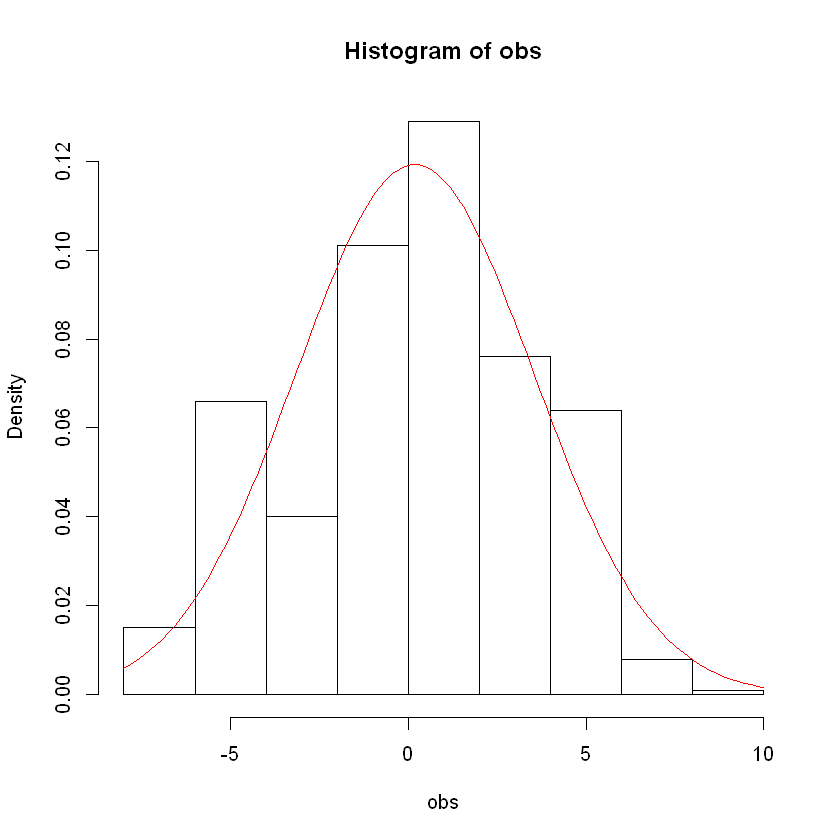

In [9]:
# des mu_k très erronées
theta2 <- theta
theta2$mu <- c(10,20,30)
res2 <- algoEM(obs,theta2)
res2
hist(obs,freq=FALSE)
curve(dnormmix(x,res2$emv),add=TRUE,col='red')

Les données  sont approchées par une simple gaussienne, car le poids des deux autres composants est quasi 0.

$emv
$emv$pi
[1] 7.923465e-01 2.076535e-01 5.468540e-09

$emv$mu
[1] -0.8376439  4.0967146  2.9134336

$emv$sig
[1] 2.9228162 1.4172748 0.2121304


$nb.iter
[1] 4

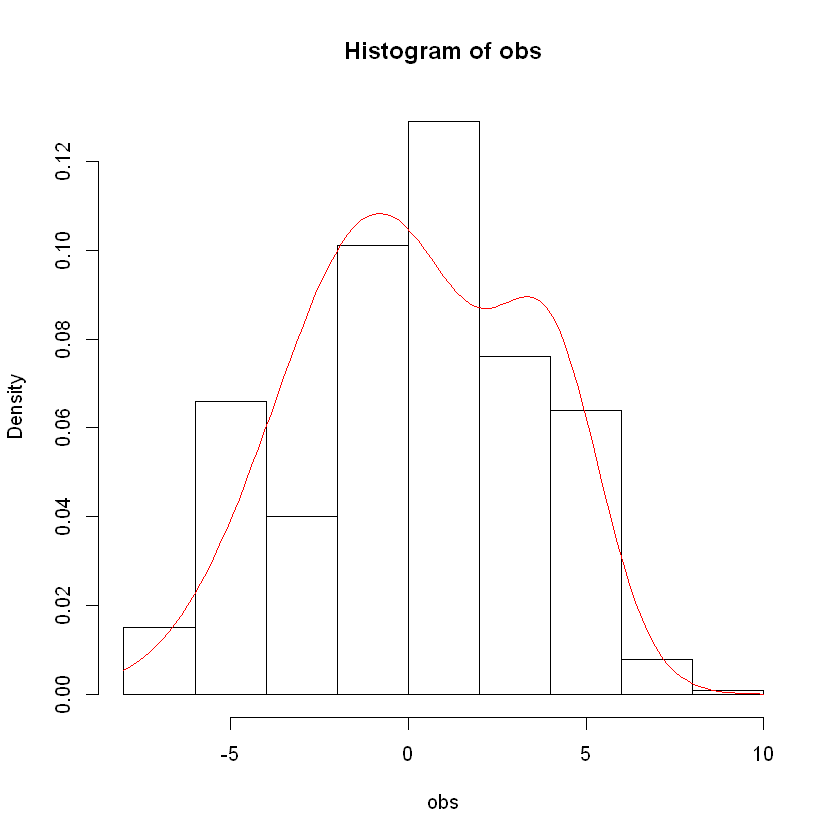

In [10]:
# des mu_k très erronées
theta3 <- theta
theta3$mu <- c(-20,20,30)
res3 <- algoEM(obs,theta3)
res3
hist(obs,freq=FALSE)
curve(dnormmix(x,res3$emv),add=TRUE,col='red')

La solution est un mélange de deux gaussienne, le troisième composant est de poids quasi 0.

$emv
$emv$pi
[1] 0.2933494 0.1852373 0.5214133

$emv$mu
[1]  0.6105862 -0.4146832  0.1624292

$emv$sig
[1] 3.249995 3.407271 3.341825


$nb.iter
[1] 2

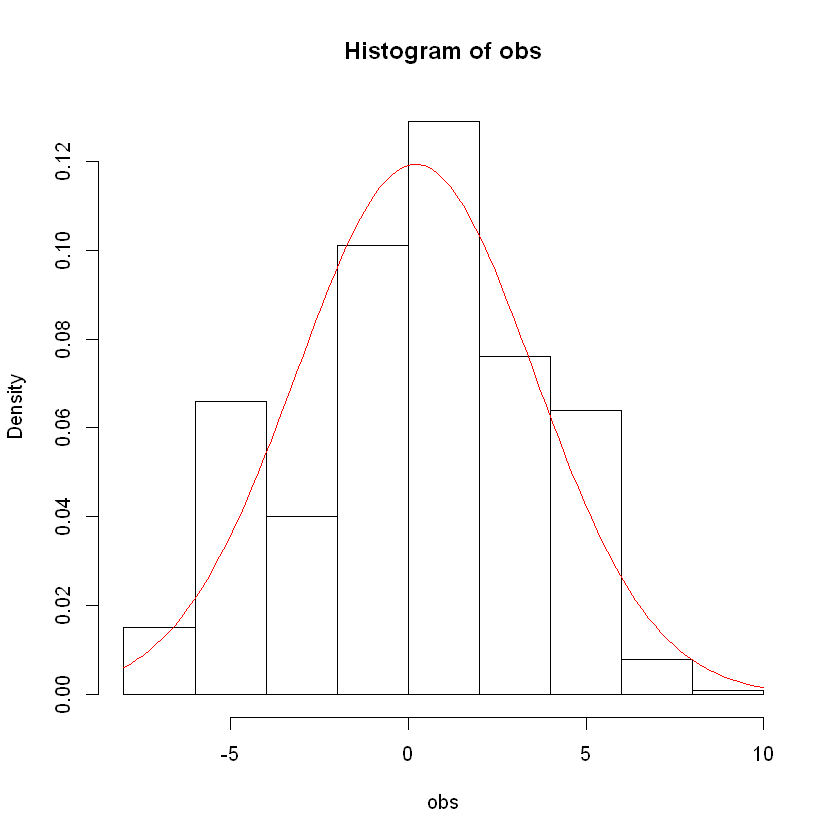

In [11]:
# des sig_k très erronées
theta4 <- theta
theta4$sig <-  c(10,10,10)  # c(.1,.1,.1), c(10,.1,10)
res4 <- algoEM(obs,theta4)
res4
hist(obs,freq=FALSE)
curve(dnormmix(x,res4$emv),add=TRUE,col='red')

Lorsque les moyennes $\mu_k$ et les proportions $\pi_k$ sont correctement initialisés, on peut utiliser des valeurs quelconques pour l'initialisations des écart-types $\sigma_k$ : l'algorithme EM converge toujours vers la bonne solution.

$emv
$emv$pi
[1] 0.2964786 0.2087628 0.4947586

$emv$mu
[1]  3.97010587 -4.80914055  0.02811663

$emv$sig
[1] 1.433832 1.183026 1.290277


$nb.iter
[1] 3

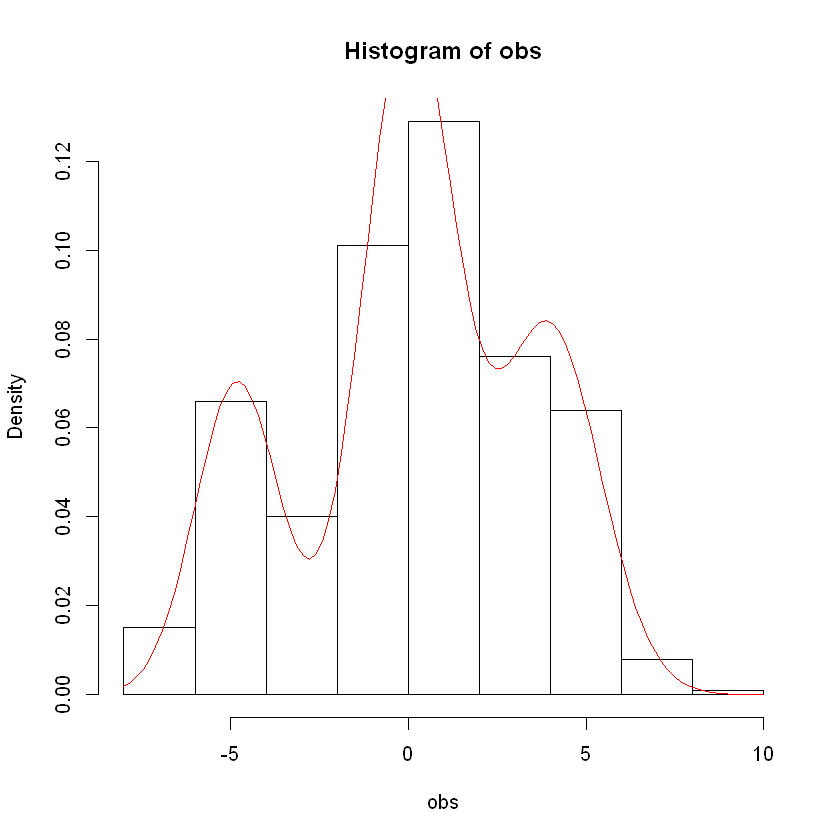

In [12]:
# des pi_k erronés
theta5 <- theta
theta5$sig <-  c(1/3,1/3,1/3)  # c(.9, .1, .1), c(.4, .5, .1) c(.85, .01, .01)
res5 <- algoEM(obs,theta5)
res5
hist(obs,freq=FALSE)
curve(dnormmix(x,res5$emv),add=TRUE,col='red')

Tant que les $\mu_m$ et $\sigma_k$ sont correctement initialisés, l'algorithme EM n'est pas sensible aux valeurs initiales des $\pi_k$.

On a vu qu'il est surtout important de bien initialiser les moyennes $\mu_k$. Or, les observations $x_i$ d'un mélange gaussien prennent des valeurs  près des moyennes $\mu_k$. On peut en déduire l'initialisation suivante :
- pour les $\mu_k$ on prend les valeurs de $K$ observations $x_i$ tirées au hasard dans l'échantillon,
- pour les $\sigma_k$ on prend l'écart-type empirique $s_x=\sqrt{\frac1n\sum_{i=1}^n(x_i-\bar x)^2}$, i.e. $\sigma_k=s_x, k=1,\dots,K$,
- pour les  $\pi_k$ on choisit des proportions équilibrées, i.e. $\pi_k=1/K, k=1,\dots,K.$

## Question 4
- Modifier la fonction **algoEM** en sorte que l'initialisation par défaut est celle précisée ci-dessus.
- Appliquer la fonction **algoEM** plusieurs fois au même échantillon avec l'initialisation par défaut. Obtient-on toujours le même résultat ?

In [13]:
algoEM <- function(obs, K, theta.init=list(pi=rep(1/K,K),mu=sample(obs,size=K),sig=rep(sd(obs),K)), R=200, epsilon=1e-3){   
  # K - ordre du mélange
  theta.old <- theta.init
  crit_arret <- FALSE
  log.vrais.old <- lvraisnorm(theta.init,obs)
  it <- 0
  while (!crit_arret && (it < R)){ 
    theta.new <- update.theta(obs, theta.old)
    log.vrais.new <- lvraisnorm(theta.new,obs)
    crit_arret <- (abs((log.vrais.new - log.vrais.old)/log.vrais.old) < epsilon)
    log.vrais.old <- log.vrais.new
    theta.old <- theta.new
    it <- it + 1
  }
  resultat <- list(emv = theta.new, nb.iter = it)
  return(resultat)
}

In [14]:
res <- algoEM(obs,3)
res

$emv
$emv$pi
[1] 0.3054206 0.3186783 0.3759011

$emv$mu
[1]  0.6116563  0.4183599 -0.3541931

$emv$sig
[1] 3.245706 3.289592 3.399361


$nb.iter
[1] 2

In [15]:
theta

$pi
[1] 0.3 0.2 0.5

$mu
[1]  4 -5  0

$sig
[1] 1.3 1.0 1.5

Afin d'ameliorer la performance, on peut appliquer l'algorithme EM avec plusierus (disons $L$) points initiaux différents  et retenir parmi  les $L$ solutions $\hat\theta_1,\dots,\hat\theta_L$ celle avec la plus grande valeur de la fonction de log-vraisemblance. Autrement dit, la solution finale $\hat\theta$ est donnée par $\hat\theta\in\{\hat\theta_1,\dots,\hat\theta_L\}$ tel que
$$\ell(\hat\theta) \geq\ell(\hat\theta_l),\qquad l=1,\dots,L$$

## Question 5
Ecrire une fonction **EMgauss** qui performe la procédure décrite ci-dessus. Cette fonction prend en argument l'échantillon **obs**, le nombre de composants **K** et le nombre de points initiaux souhaités **L**.


In [16]:
EMgauss <- function(obs,K,L){
    
    
    return(theta)
}

In [17]:
EMgauss <- function(obs,K,L=20){
  resEM <- vector("list",L)
  for (l in 1:L)
    resEM[[l]] <- algoEM(obs,K)$emv
  logvrais <- sapply(resEM, function(x) lvraisnorm(x,obs))
  best.run <- which.max(logvrais)    
  theta <- resEM[[best.run]]   
  return(theta)
}

In [18]:
EMgauss(obs,3)

$pi
[1] 0.4467319 0.3879740 0.1652941

$mu
[1]  1.5222124  0.8797254 -5.0475999

$sig
[1] 2.507096 2.631588 1.059221

## Données réelles
On reprend les données réelles vues en cours :
- les données de longueurs d'ailes des passereaux (**ailes**)
- les données du taux de chlorure dans le sang chez 542 personnes (**chlor**).

Les données sont disponibles dans le fichier *donneesmelange.RData* que vous pouvez charger par l'instruction suivante : 

In [19]:
load('donneesmelange.RData')
table(ailes)
table(chlor)

ailes
82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 98 
 5  3 12 36 55 45 21 13 15 34 59 48 16 12  6  1 

chlor
 88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 
  2   3   4   5   7   5  13  13  27  36  40  72  68  80  47  43  33  19   6   6 
108 109 111 113 115 
  4   5   2   1   1 

## Question 6
Pour chaque jeu de données :
- tracer l'histogramme des données,
- ajuster **une** loi normale aux données et rajouter-la à la figure
- appliquer l'algorithme EM pour un mélange gaussiens d'ordre 2 et superposer la dénsité estimée à l'histogramme.
- Commenter.

$pi
[1] 0.5056463 0.4943537

$mu
[1] 92.37446 86.19619

$sig
[1] 1.543551 1.543299

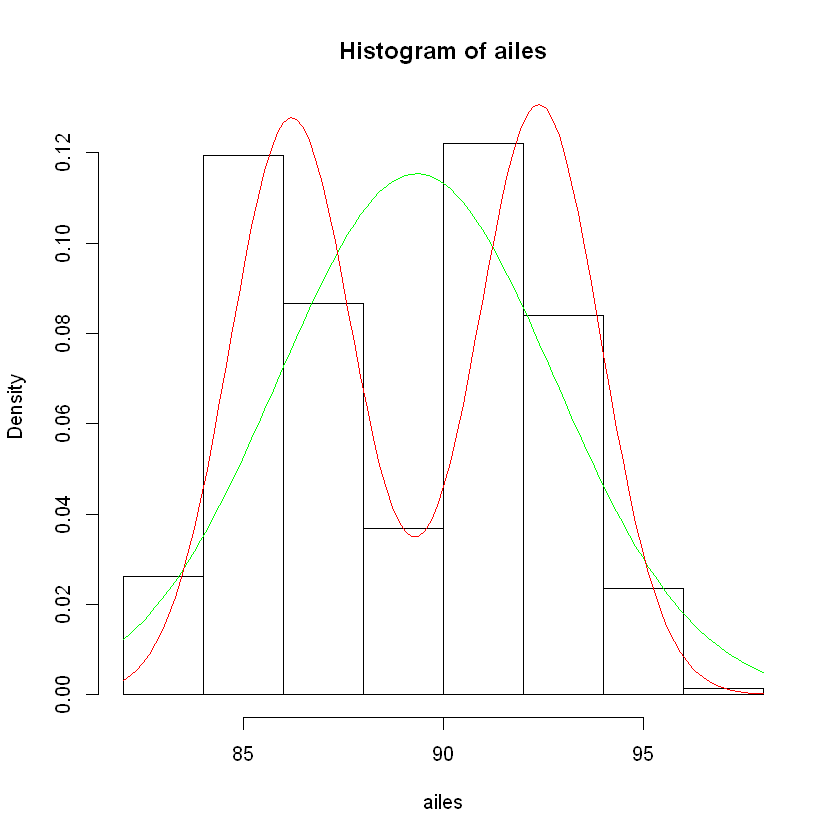

In [20]:
mu.ailes <- mean(ailes)
sig.ailes <- sd(ailes)
theta.ailes <- EMgauss(ailes,2)
theta.ailes
ymax <- max(c(dnorm(ailes,mu.ailes,sig.ailes),dnormmix(ailes,theta.ailes)))
hist(ailes,freq=FALSE,ylim=c(0,ymax))
curve(dnorm(x,mu.ailes,sig.ailes),add=TRUE,col='green')
curve(dnormmix(x,theta.ailes),add=TRUE,col='red')

$pi
[1] 0.3630643 0.6369357

$mu
[1]  99.11081 100.48078

$sig
[1] 5.020491 2.524254

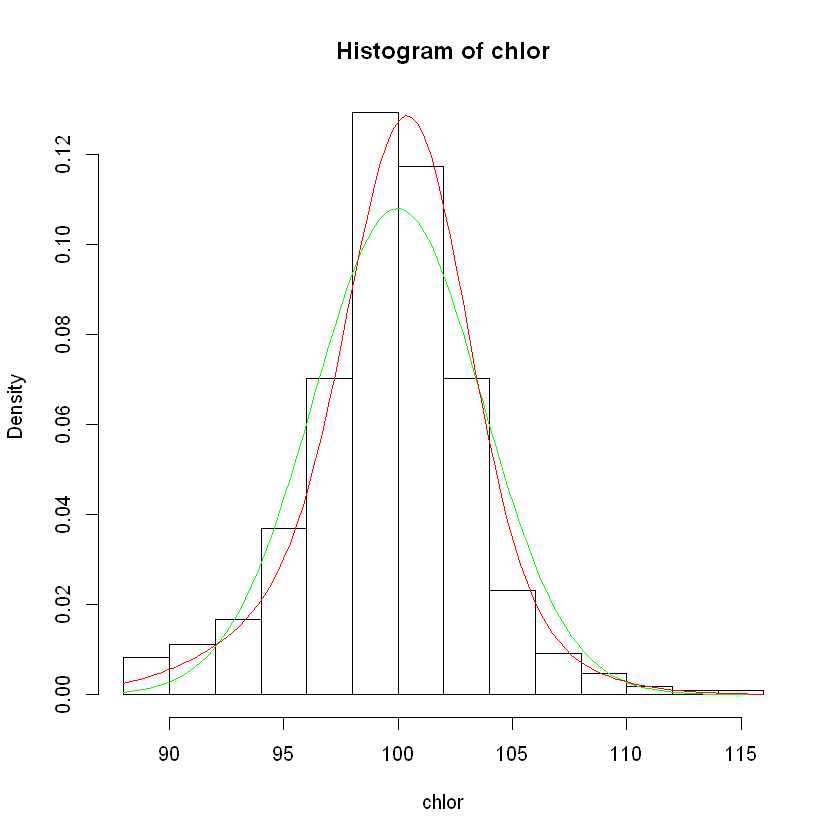

In [21]:
set.seed(1984)
mu.chlor <- mean(chlor)
sig.chlor <- sd(chlor)
theta.chlor <- EMgauss(chlor,2,100)
theta.chlor
ymax <- max(c(dnorm(chlor,mu.chlor,sig.chlor),dnormmix(chlor,theta.chlor)))
hist(chlor,freq=FALSE,ylim=c(0,ymax))
curve(dnorm(x,mu.chlor,sig.chlor),add=TRUE,col='green')
curve(dnormmix(x,theta.chlor),add=TRUE,col='red')